In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

print("✓ Libraries imported successfully")

✓ Libraries imported successfully


In [2]:
# Load cleaned datasets
df_daily = pd.read_csv('../outputs/df_clean_daily.csv')
df_monthly = pd.read_csv('../outputs/monthly_trends_data.csv')
df_monthly_district = pd.read_pickle('../outputs/df_monthly_district.pkl')
df_monthly_state = pd.read_pickle('../outputs/df_monthly_state.pkl')

print(f"✓ Daily data loaded: {len(df_daily):,} records")
print(f"✓ Monthly data loaded: {len(df_monthly):,} records")
print(f"✓ Monthly district data: {len(df_monthly_district):,} records")
print(f"✓ Monthly state data: {len(df_monthly_state):,} records")

✓ Daily data loaded: 2,375,882 records
✓ Monthly data loaded: 10 records
✓ Monthly district data: 7,062 records
✓ Monthly state data: 385 records


## 1. Child vs Adult Updates Comparison
### Scatter plots and correlation analysis

In [3]:
# Calculate correlation between child and adult updates
correlation = df_daily[['demo_age_5_17', 'demo_age_17_']].corr().iloc[0, 1]

print(f"Correlation between Child and Adult updates: {correlation:.4f}")
print(f"Correlation strength: {'Strong' if abs(correlation) > 0.7 else 'Moderate' if abs(correlation) > 0.4 else 'Weak'}")

Correlation between Child and Adult updates: 0.8507
Correlation strength: Strong


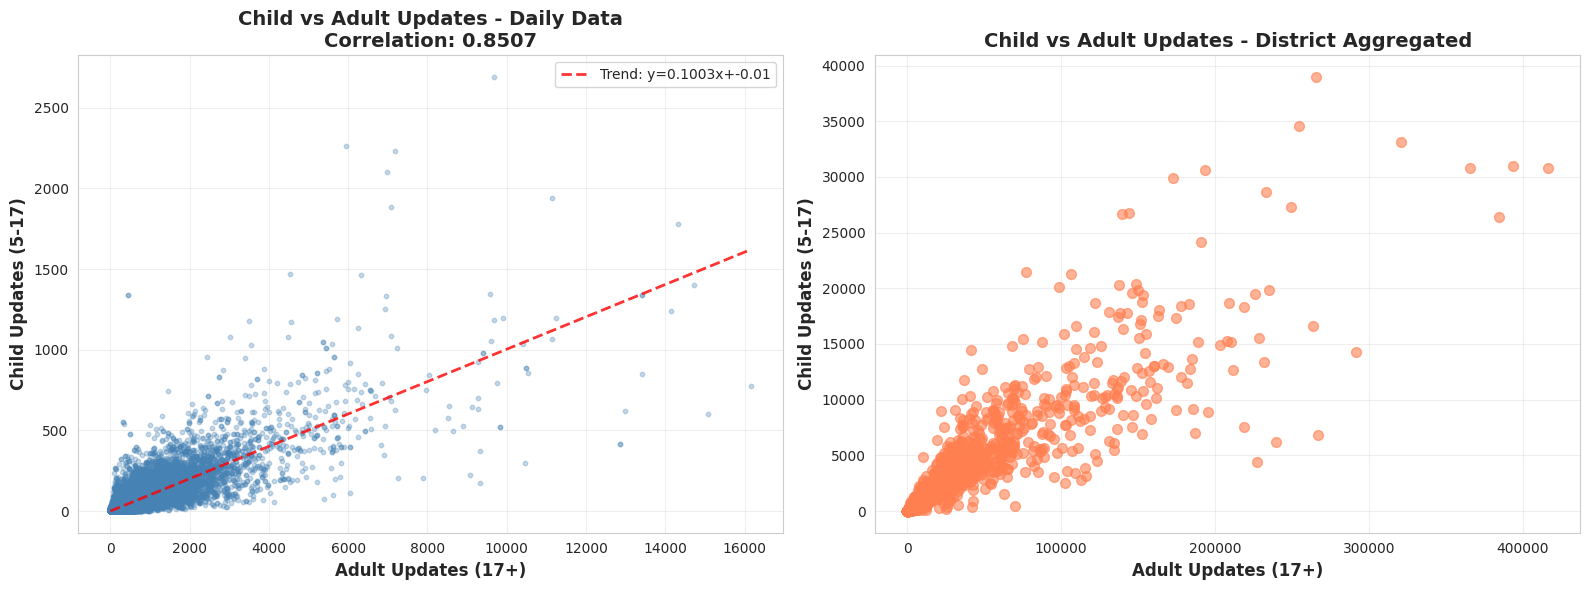

✓ Scatter plots created and saved


In [4]:
# Scatter plot: Child vs Adult updates (daily level)
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Full scatter plot
axes[0].scatter(df_daily['demo_age_17_'], df_daily['demo_age_5_17'], 
                alpha=0.3, s=10, color='steelblue')
axes[0].set_xlabel('Adult Updates (17+)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Child Updates (5-17)', fontsize=12, fontweight='bold')
axes[0].set_title(f'Child vs Adult Updates - Daily Data\nCorrelation: {correlation:.4f}', 
                  fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Add regression line
z = np.polyfit(df_daily['demo_age_17_'], df_daily['demo_age_5_17'], 1)
p = np.poly1d(z)
axes[0].plot(df_daily['demo_age_17_'].sort_values(), 
             p(df_daily['demo_age_17_'].sort_values()), 
             "r--", alpha=0.8, linewidth=2, label=f'Trend: y={z[0]:.4f}x+{z[1]:.2f}')
axes[0].legend()

# Scatter plot with aggregated data (to reduce overplotting)
df_agg = df_daily.groupby(['state', 'district'])[['demo_age_5_17', 'demo_age_17_']].sum().reset_index()
axes[1].scatter(df_agg['demo_age_17_'], df_agg['demo_age_5_17'], 
                alpha=0.6, s=50, color='coral')
axes[1].set_xlabel('Adult Updates (17+)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Child Updates (5-17)', fontsize=12, fontweight='bold')
axes[1].set_title('Child vs Adult Updates - District Aggregated', 
                  fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../outputs/bivariate_child_vs_adult_scatter.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Scatter plots created and saved")

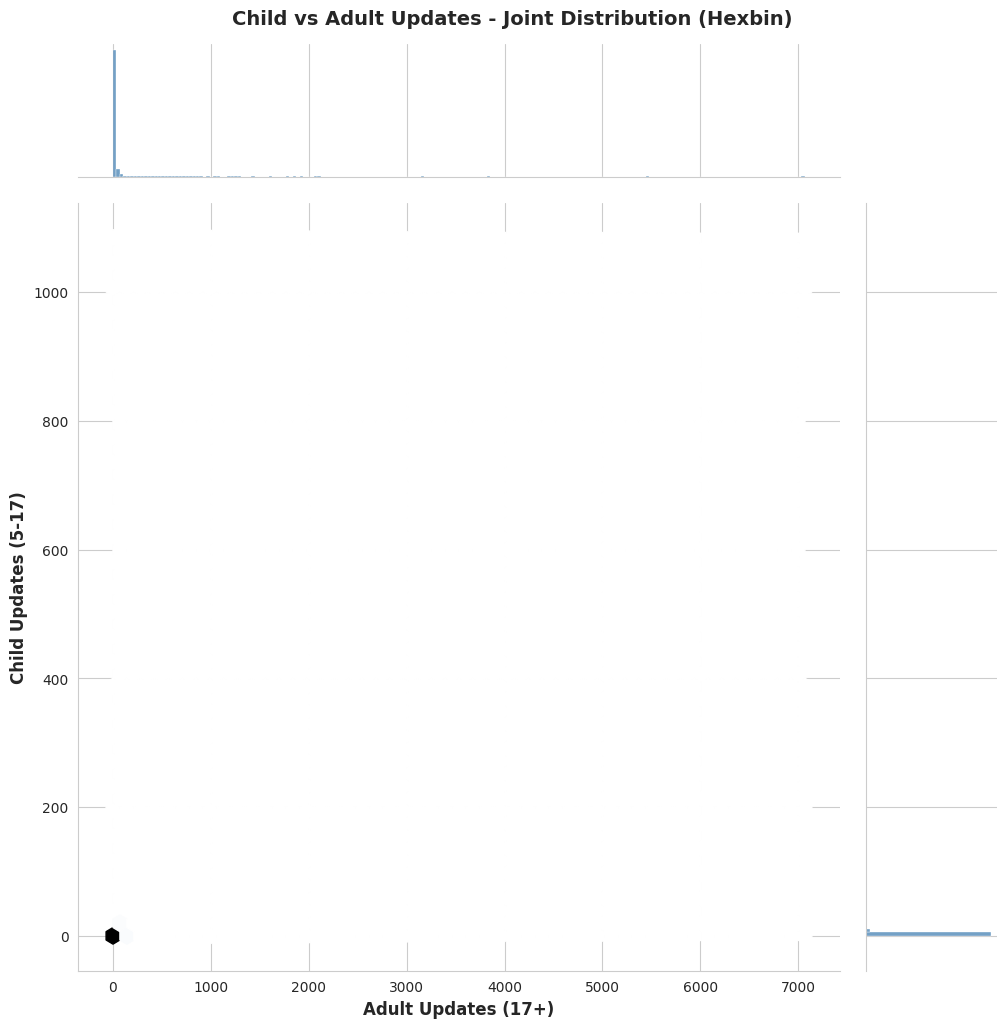

✓ Joint plot created and saved


In [5]:
# Joint plot for detailed distribution view
# Sample data for better visualization (full dataset might be too dense)
df_sample = df_daily.sample(n=min(10000, len(df_daily)), random_state=42)

g = sns.jointplot(data=df_sample, x='demo_age_17_', y='demo_age_5_17', 
                  kind='hex', height=10, color='steelblue')
g.set_axis_labels('Adult Updates (17+)', 'Child Updates (5-17)', fontsize=12, fontweight='bold')
g.fig.suptitle('Child vs Adult Updates - Joint Distribution (Hexbin)', 
               fontsize=14, fontweight='bold', y=1.02)

plt.savefig('../outputs/bivariate_child_vs_adult_jointplot.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Joint plot created and saved")

## 2. Age Update Ratio Calculation
### Formula: demo_age_5_17 / demo_age_17+

In [6]:
# Calculate age update ratio (avoiding division by zero)
df_daily['age_ratio'] = df_daily['demo_age_5_17'] / (df_daily['demo_age_17_'] + 1)
df_monthly_district['age_ratio'] = df_monthly_district['demo_age_5_17'] / (df_monthly_district['demo_age_17_'] + 1)

# Summary statistics
print("Age Update Ratio Statistics:")
print(df_daily['age_ratio'].describe())
print(f"\nMedian ratio: {df_daily['age_ratio'].median():.4f}")
print(f"Mode (most common): {df_daily['age_ratio'].mode().values[0]:.4f}")

Age Update Ratio Statistics:
count    2.375882e+06
mean     1.161072e-01
std      2.441755e-01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      1.428571e-01
max      2.400000e+01
Name: age_ratio, dtype: float64

Median ratio: 0.0000


Mode (most common): 0.0000


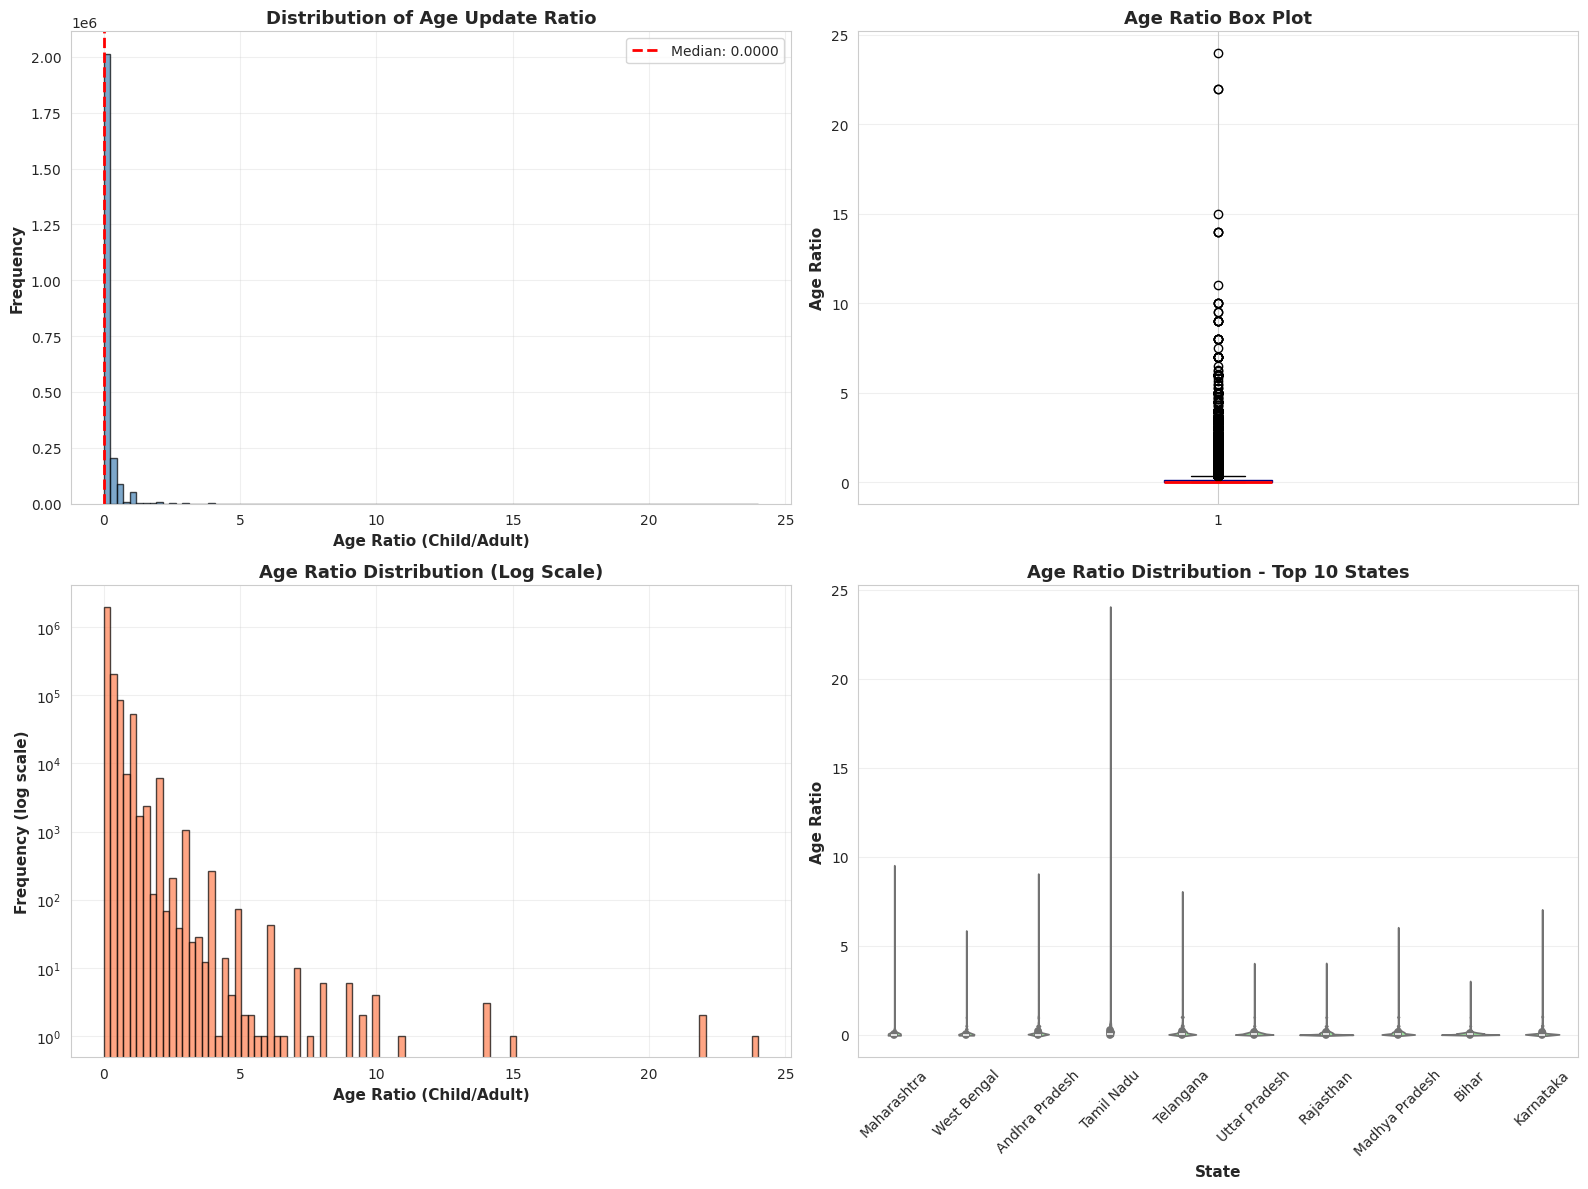

✓ Age ratio distribution plots created and saved


In [7]:
# Age ratio distribution plots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Histogram with KDE
axes[0, 0].hist(df_daily['age_ratio'], bins=100, edgecolor='black', alpha=0.7, color='steelblue')
axes[0, 0].set_xlabel('Age Ratio (Child/Adult)', fontsize=11, fontweight='bold')
axes[0, 0].set_ylabel('Frequency', fontsize=11, fontweight='bold')
axes[0, 0].set_title('Distribution of Age Update Ratio', fontsize=13, fontweight='bold')
axes[0, 0].axvline(df_daily['age_ratio'].median(), color='red', linestyle='--', 
                   linewidth=2, label=f'Median: {df_daily['age_ratio'].median():.4f}')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Box plot
axes[0, 1].boxplot(df_daily['age_ratio'], vert=True, patch_artist=True,
                   boxprops=dict(facecolor='lightblue', color='navy'),
                   medianprops=dict(color='red', linewidth=2))
axes[0, 1].set_ylabel('Age Ratio', fontsize=11, fontweight='bold')
axes[0, 1].set_title('Age Ratio Box Plot', fontsize=13, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3, axis='y')

# Log-scale histogram (for better view of tail)
axes[1, 0].hist(df_daily['age_ratio'], bins=100, edgecolor='black', alpha=0.7, color='coral')
axes[1, 0].set_xlabel('Age Ratio (Child/Adult)', fontsize=11, fontweight='bold')
axes[1, 0].set_ylabel('Frequency (log scale)', fontsize=11, fontweight='bold')
axes[1, 0].set_yscale('log')
axes[1, 0].set_title('Age Ratio Distribution (Log Scale)', fontsize=13, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

# Violin plot by state (top 10 states)
top_states = df_daily.groupby('state')['demo_age_5_17'].sum().nlargest(10).index
df_top_states = df_daily[df_daily['state'].isin(top_states)]
sns.violinplot(data=df_top_states, x='state', y='age_ratio', ax=axes[1, 1], color='lightgreen')
axes[1, 1].set_xlabel('State', fontsize=11, fontweight='bold')
axes[1, 1].set_ylabel('Age Ratio', fontsize=11, fontweight='bold')
axes[1, 1].set_title('Age Ratio Distribution - Top 10 States', fontsize=13, fontweight='bold')
axes[1, 1].tick_params(axis='x', rotation=45)
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('../outputs/bivariate_age_ratio_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Age ratio distribution plots created and saved")

## 3. District-wise Differences
### Bar charts and top/bottom districts identification

In [8]:
# Calculate district-level aggregates
district_summary = df_monthly_district.groupby('district').agg({
    'demo_age_5_17': 'sum',
    'demo_age_17_': 'sum',
    'age_ratio': 'mean'
}).reset_index()

district_summary['total_updates'] = district_summary['demo_age_5_17'] + district_summary['demo_age_17_']

# Identify top and bottom districts
top_districts_total = district_summary.nlargest(15, 'total_updates')
top_districts_ratio = district_summary.nlargest(15, 'age_ratio')
bottom_districts_ratio = district_summary.nsmallest(15, 'age_ratio')

print("Top 15 Districts by Total Updates:")
print(top_districts_total[['district', 'demo_age_5_17', 'demo_age_17_', 'total_updates']].to_string(index=False))

print("\n" + "="*80 + "\n")

print("Top 15 Districts by Age Ratio (Highest Child proportion):")
print(top_districts_ratio[['district', 'age_ratio', 'demo_age_5_17', 'demo_age_17_']].to_string(index=False))

print("\n" + "="*80 + "\n")

print("Bottom 15 Districts by Age Ratio (Lowest Child proportion):")
print(bottom_districts_ratio[['district', 'age_ratio', 'demo_age_5_17', 'demo_age_17_']].to_string(index=False))

Top 15 Districts by Total Updates:
         district  demo_age_5_17  demo_age_17_  total_updates
             Pune          30818        416445         447263
            Thane          31000        393839         424839
South 24 Parganas          26420        384315         410735
      Murshidabad          30835        365811         396646
            Surat          33152        320760         353912
North 24 Parganas          14248        291699         305947
 North West Delhi          38974        265785         304759
        Bengaluru          34555        254739         289294
   Uttar Dinajpur          16571        263922         280493
           Jaipur          27315        249676         276991
          Solapur           6847        266976         273823
        Ahmedabad          28648        233127         261775
        Hyderabad          34140        224945         259085
         Bareilly          19808        234829         254637
       Aurangabad          16103   

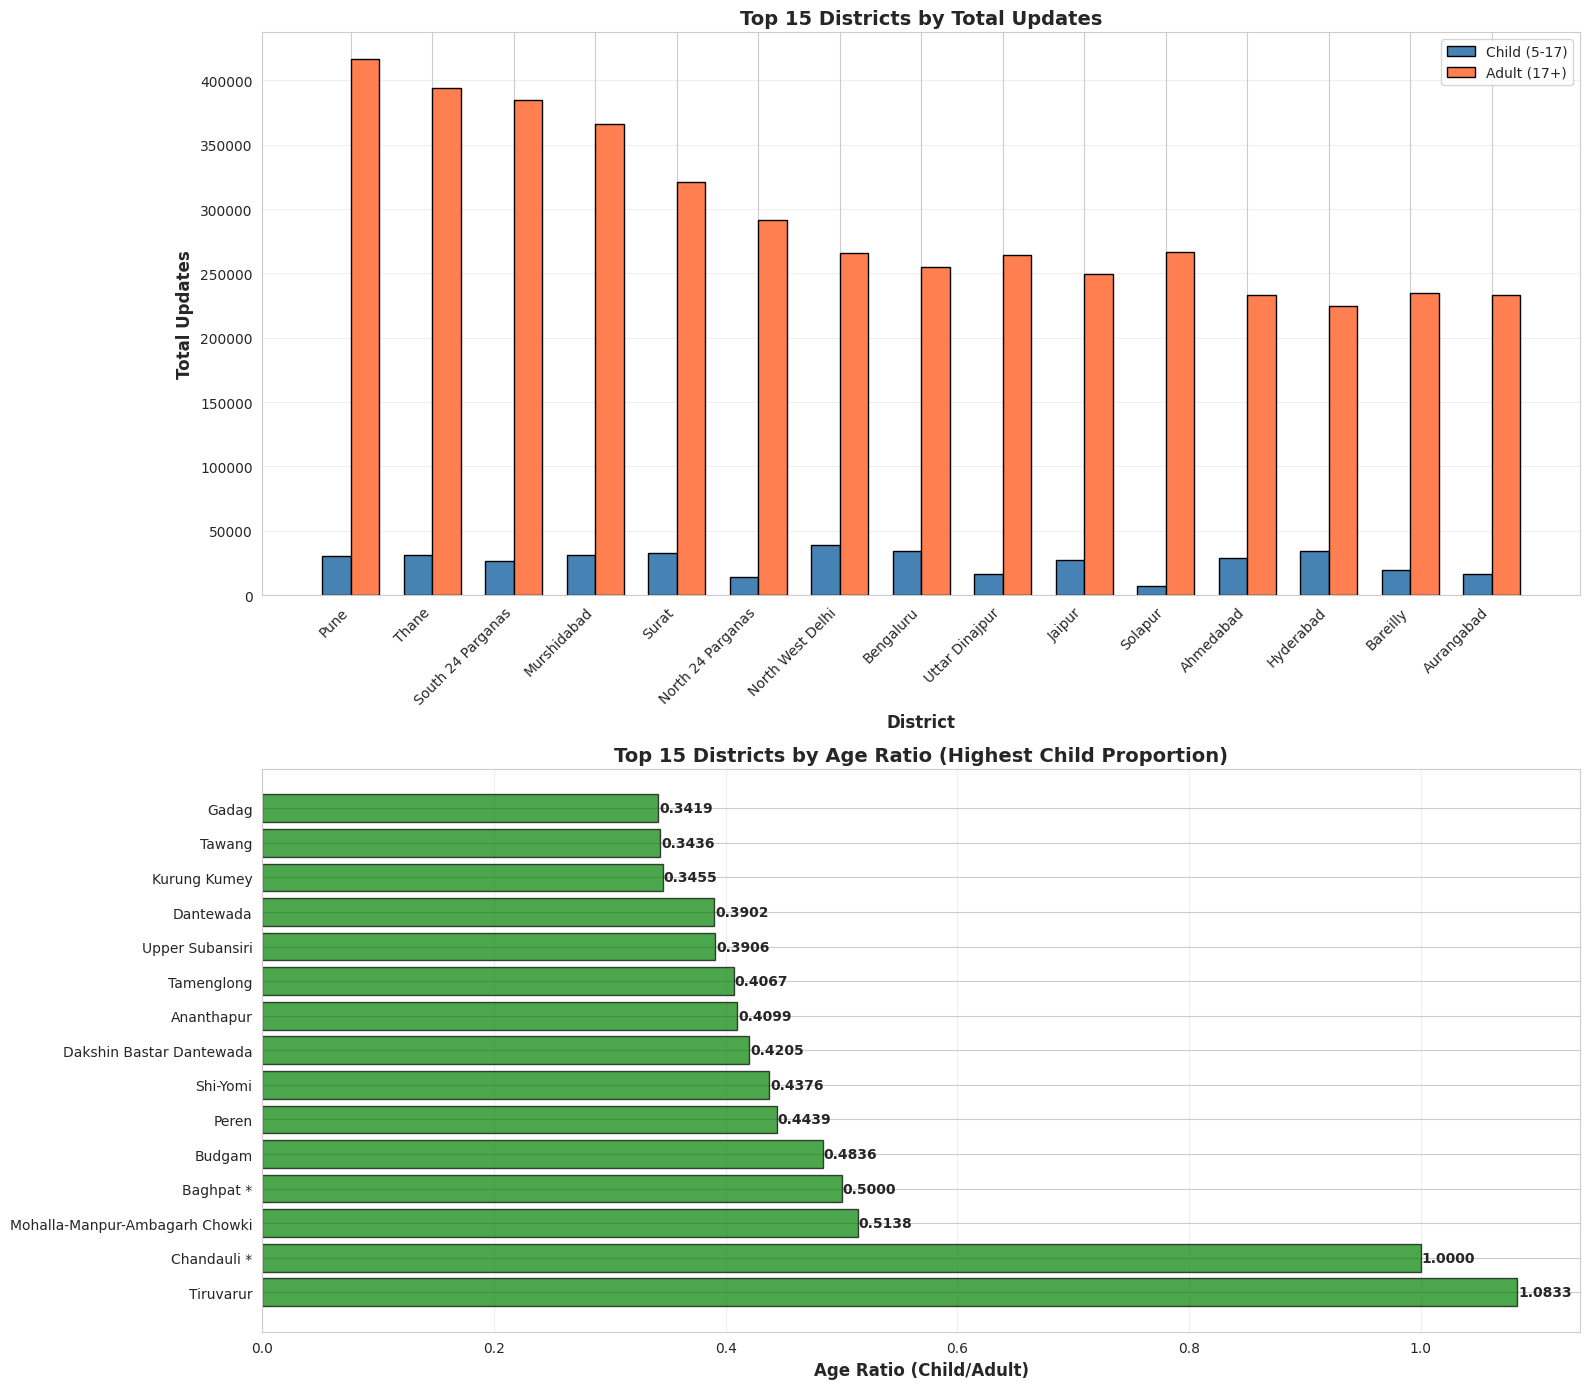

✓ District comparison bar charts created and saved


In [9]:
# Bar charts for top districts
fig, axes = plt.subplots(2, 1, figsize=(16, 14))

# Top 15 districts by total updates
x = np.arange(len(top_districts_total))
width = 0.35

axes[0].bar(x - width/2, top_districts_total['demo_age_5_17'], width, 
            label='Child (5-17)', color='steelblue', edgecolor='black')
axes[0].bar(x + width/2, top_districts_total['demo_age_17_'], width, 
            label='Adult (17+)', color='coral', edgecolor='black')
axes[0].set_xlabel('District', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Total Updates', fontsize=12, fontweight='bold')
axes[0].set_title('Top 15 Districts by Total Updates', fontsize=14, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(top_districts_total['district'], rotation=45, ha='right')
axes[0].legend()
axes[0].grid(True, alpha=0.3, axis='y')

# Top 15 districts by age ratio
axes[1].barh(range(len(top_districts_ratio)), top_districts_ratio['age_ratio'], 
             color='green', edgecolor='black', alpha=0.7)
axes[1].set_yticks(range(len(top_districts_ratio)))
axes[1].set_yticklabels(top_districts_ratio['district'])
axes[1].set_xlabel('Age Ratio (Child/Adult)', fontsize=12, fontweight='bold')
axes[1].set_title('Top 15 Districts by Age Ratio (Highest Child Proportion)', 
                  fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='x')

# Add values on bars
for i, v in enumerate(top_districts_ratio['age_ratio']):
    axes[1].text(v + 0.001, i, f'{v:.4f}', va='center', fontweight='bold')

plt.tight_layout()
plt.savefig('../outputs/bivariate_district_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ District comparison bar charts created and saved")

## 4. Pincode Concentration vs Update Volume
### Scatter plots and concentration metrics

In [10]:
# Calculate pincode-level statistics
pincode_summary = df_daily.groupby('pincode').agg({
    'demo_age_5_17': ['sum', 'mean', 'std'],
    'demo_age_17_': ['sum', 'mean', 'std'],
    'date': 'count'  # Number of days with updates
}).reset_index()

pincode_summary.columns = ['pincode', 'child_sum', 'child_mean', 'child_std', 
                           'adult_sum', 'adult_mean', 'adult_std', 'update_days']

pincode_summary['total_updates'] = pincode_summary['child_sum'] + pincode_summary['adult_sum']
pincode_summary['age_ratio'] = pincode_summary['child_sum'] / (pincode_summary['adult_sum'] + 1)

# Calculate concentration metrics
total_updates_all = pincode_summary['total_updates'].sum()
pincode_summary['update_share'] = (pincode_summary['total_updates'] / total_updates_all) * 100
pincode_summary = pincode_summary.sort_values('total_updates', ascending=False).reset_index(drop=True)
pincode_summary['cumulative_share'] = pincode_summary['update_share'].cumsum()

# Concentration ratios
top_1pct = len(pincode_summary) // 100
top_5pct = len(pincode_summary) * 5 // 100
top_10pct = len(pincode_summary) // 10

concentration_metrics = {
    'Top 1% pincodes': pincode_summary.iloc[:top_1pct]['update_share'].sum(),
    'Top 5% pincodes': pincode_summary.iloc[:top_5pct]['update_share'].sum(),
    'Top 10% pincodes': pincode_summary.iloc[:top_10pct]['update_share'].sum(),
    'Top 20 pincodes': pincode_summary.iloc[:20]['update_share'].sum()
}

print("Pincode Concentration Metrics:")
print("="*60)
for metric, value in concentration_metrics.items():
    print(f"{metric}: {value:.2f}% of total updates")

print(f"\nTotal unique pincodes: {len(pincode_summary):,}")
print(f"Median updates per pincode: {pincode_summary['total_updates'].median():,.0f}")
print(f"Mean updates per pincode: {pincode_summary['total_updates'].mean():,.0f}")

Pincode Concentration Metrics:
Top 1% pincodes: 12.53% of total updates
Top 5% pincodes: 32.29% of total updates
Top 10% pincodes: 46.74% of total updates
Top 20 pincodes: 2.67% of total updates

Total unique pincodes: 19,772
Median updates per pincode: 1,196
Mean updates per pincode: 2,525


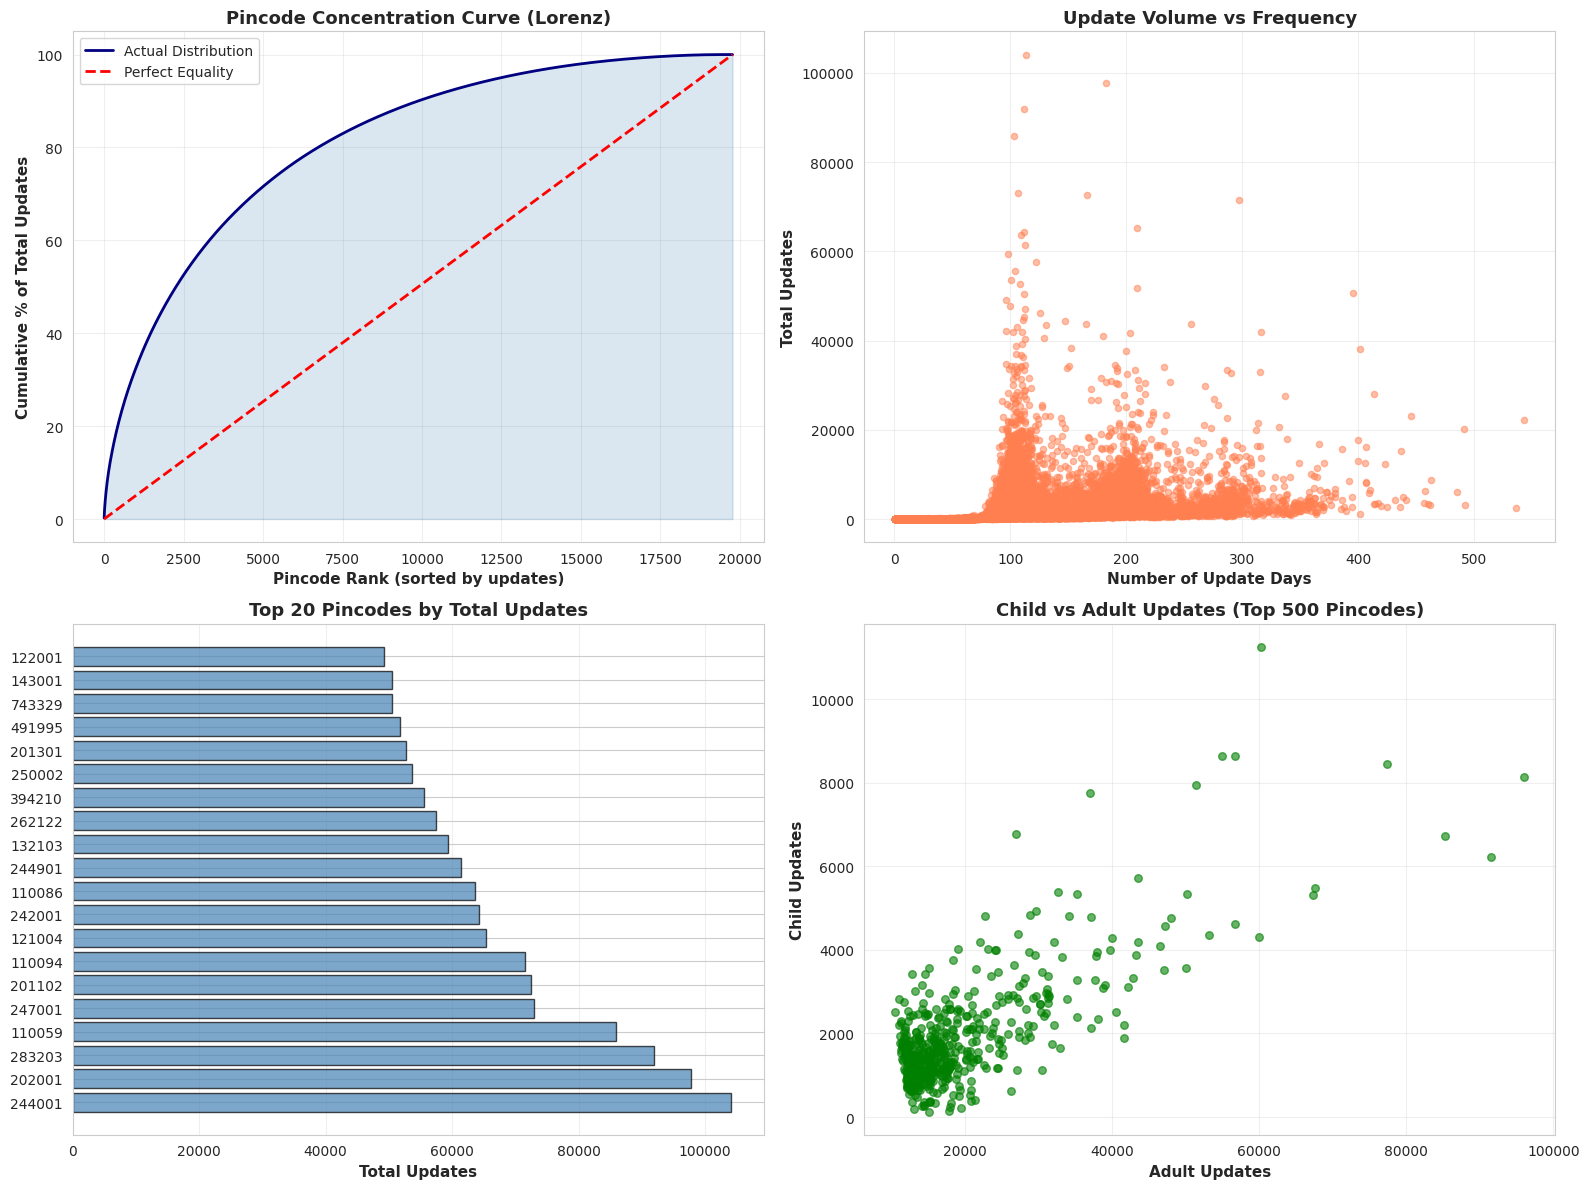

✓ Pincode concentration visualizations created and saved


In [11]:
# Visualization: Pincode concentration analysis
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Lorenz curve (concentration curve)
axes[0, 0].plot(range(len(pincode_summary)), pincode_summary['cumulative_share'], 
                linewidth=2, color='navy', label='Actual Distribution')
axes[0, 0].plot([0, len(pincode_summary)], [0, 100], 'r--', linewidth=2, 
                label='Perfect Equality')
axes[0, 0].set_xlabel('Pincode Rank (sorted by updates)', fontsize=11, fontweight='bold')
axes[0, 0].set_ylabel('Cumulative % of Total Updates', fontsize=11, fontweight='bold')
axes[0, 0].set_title('Pincode Concentration Curve (Lorenz)', fontsize=13, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].fill_between(range(len(pincode_summary)), 0, pincode_summary['cumulative_share'], 
                        alpha=0.2, color='steelblue')

# Scatter: Total updates vs Update frequency (days)
axes[0, 1].scatter(pincode_summary['update_days'], pincode_summary['total_updates'], 
                   alpha=0.5, s=20, color='coral')
axes[0, 1].set_xlabel('Number of Update Days', fontsize=11, fontweight='bold')
axes[0, 1].set_ylabel('Total Updates', fontsize=11, fontweight='bold')
axes[0, 1].set_title('Update Volume vs Frequency', fontsize=13, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)

# Top 20 pincodes bar chart
top_20 = pincode_summary.head(20)
axes[1, 0].barh(range(len(top_20)), top_20['total_updates'], 
                color='steelblue', edgecolor='black', alpha=0.7)
axes[1, 0].set_yticks(range(len(top_20)))
axes[1, 0].set_yticklabels(top_20['pincode'])
axes[1, 0].set_xlabel('Total Updates', fontsize=11, fontweight='bold')
axes[1, 0].set_title('Top 20 Pincodes by Total Updates', fontsize=13, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3, axis='x')

# Scatter: Child vs Adult updates at pincode level (top 500 for clarity)
top_500 = pincode_summary.head(500)
axes[1, 1].scatter(top_500['adult_sum'], top_500['child_sum'], 
                   alpha=0.6, s=30, color='green')
axes[1, 1].set_xlabel('Adult Updates', fontsize=11, fontweight='bold')
axes[1, 1].set_ylabel('Child Updates', fontsize=11, fontweight='bold')
axes[1, 1].set_title('Child vs Adult Updates (Top 500 Pincodes)', fontsize=13, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../outputs/bivariate_pincode_concentration.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Pincode concentration visualizations created and saved")

## Summary: Key Bivariate Findings

In [12]:
# Generate summary report
summary_report = f"""
{'='*80}
BIVARIATE ANALYSIS SUMMARY - ADIEWS PROJECT
{'='*80}

1. CHILD VS ADULT UPDATES CORRELATION
   - Correlation coefficient: {correlation:.4f}
   - Relationship: {('Strong positive' if correlation > 0.7 else 'Moderate positive' if correlation > 0.4 else 'Weak positive')}
   - Linear trend: y = {z[0]:.4f}x + {z[1]:.2f}

2. AGE UPDATE RATIO DISTRIBUTION
   - Mean ratio: {df_daily['age_ratio'].mean():.4f}
   - Median ratio: {df_daily['age_ratio'].median():.4f}
   - Std deviation: {df_daily['age_ratio'].std():.4f}
   - 25th percentile: {df_daily['age_ratio'].quantile(0.25):.4f}
   - 75th percentile: {df_daily['age_ratio'].quantile(0.75):.4f}

3. DISTRICT-LEVEL INSIGHTS
   - Total districts analyzed: {len(district_summary)}
   - Highest ratio district: {top_districts_ratio.iloc[0]['district']} ({top_districts_ratio.iloc[0]['age_ratio']:.4f})
   - Lowest ratio district: {bottom_districts_ratio.iloc[0]['district']} ({bottom_districts_ratio.iloc[0]['age_ratio']:.4f})
   - Top district by volume: {top_districts_total.iloc[0]['district']} ({top_districts_total.iloc[0]['total_updates']:,.0f} updates)

4. PINCODE CONCENTRATION METRICS
   - Total unique pincodes: {len(pincode_summary):,}
   - Top 1% pincodes account for: {concentration_metrics['Top 1% pincodes']:.2f}% of updates
   - Top 5% pincodes account for: {concentration_metrics['Top 5% pincodes']:.2f}% of updates
   - Top 10% pincodes account for: {concentration_metrics['Top 10% pincodes']:.2f}% of updates
   - Top 20 pincodes account for: {concentration_metrics['Top 20 pincodes']:.2f}% of updates

{'='*80}
"""

print(summary_report)

# Save summary to file
with open('../outputs/bivariate_analysis_summary.txt', 'w') as f:
    f.write(summary_report)

print("\n✓ Summary report saved to outputs/bivariate_analysis_summary.txt")


BIVARIATE ANALYSIS SUMMARY - ADIEWS PROJECT

1. CHILD VS ADULT UPDATES CORRELATION
   - Correlation coefficient: 0.8507
   - Relationship: Strong positive
   - Linear trend: y = 0.1003x + -0.01

2. AGE UPDATE RATIO DISTRIBUTION
   - Mean ratio: 0.1161
   - Median ratio: 0.0000
   - Std deviation: 0.2442
   - 25th percentile: 0.0000
   - 75th percentile: 0.1429

3. DISTRICT-LEVEL INSIGHTS
   - Total districts analyzed: 967
   - Highest ratio district: Tiruvarur (1.0833)
   - Lowest ratio district: 100000 (0.0000)
   - Top district by volume: Pune (447,263 updates)

4. PINCODE CONCENTRATION METRICS
   - Total unique pincodes: 19,772
   - Top 1% pincodes account for: 12.53% of updates
   - Top 5% pincodes account for: 32.29% of updates
   - Top 10% pincodes account for: 46.74% of updates
   - Top 20 pincodes account for: 2.67% of updates



✓ Summary report saved to outputs/bivariate_analysis_summary.txt


In [13]:
# Save processed datasets for further analysis
pincode_summary.to_csv('../outputs/pincode_summary.csv', index=False)
district_summary.to_csv('../outputs/district_summary.csv', index=False)

print("✓ Processed datasets saved:")
print("  - outputs/pincode_summary.csv")
print("  - outputs/district_summary.csv")
print("\n✓✓✓ BIVARIATE ANALYSIS COMPLETED SUCCESSFULLY ✓✓✓")

✓ Processed datasets saved:
  - outputs/pincode_summary.csv
  - outputs/district_summary.csv

✓✓✓ BIVARIATE ANALYSIS COMPLETED SUCCESSFULLY ✓✓✓
